## Playing the Dice Blackjack with Q-learning agent

**Prepared by:** Makar Korchagin, Ilya Zherebtsov, Rinat Prochii, Aibek Akhmetkazy and Mukhail Gubanov

In [14]:
import os

import gymnasium as gym
import numpy as np
from tqdm import trange

from src.agent import QLearningAgent
from src.env import DiceBlackJack
from src.visualization import (
    convert_q_table,
    get_rewards_stats,
    mp4_to_gif,
    plot_policy_tables_18,
    show_inference_stats,
    show_training_stats,
)


In [15]:
os.makedirs("./analysis", exist_ok=True)

You may unveil the training process by redirecting the logs to the file and analyse then later.

In [16]:
import logging

logging.basicConfig(
    level=logging.WARNING,
    filemode="w",
    filename="./analysis/training.log",
    format="[%(levelname)s] %(message)s",
)
logging.logProcesses = False

### Environment

The Balckjack game is the game, that use a pair of dice instead of cards as a source of randomness. To get familiar with the game rules, you may see the original source at this [link](https://www.chessandpoker.com/dice_blackjack.html).

#### State space

The Dice Blackjack has a state vector $\bold{s} = [p, d_1, d_2] \in \mathbb{S}$, 

where:

$p \in [0, 27] \subset \mathbb{N}_0$ - the sum of the previous rolls;

$d_1, d_2 \in [0, 6] \subset \mathbb{N}_0$ - the rolled values of first and second die (0 value is used to indicate final states, when no rolling is available).

#### Action space

The action space consists of 6 actions: 

0 - hit the first die (**H1**);
1 - hit the second die (**H2**);
2 - hit the sum (**HΣ**);

3 - stack the first die (**S1**);
4 - stack the second die (**S2**);
5 - stack the sum (**SΣ**).

#### Rewards

The game ends with one of four possible rewards:

-1 - the player got busted (scored more than 21 points) or got less points than the dealer;

0 - the game ended with a tie;

1 - the player won over the dealer or dealer got busted;

2 - the player rolled a Blackjack combination (2 double values in first two rolls).

You may play the game by launching the environment file `/src/env.py` directly.

In [17]:
learning_rate = 0.10
n_episodes = 500_000

env = DiceBlackJack()
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

agent = QLearningAgent(env=env, n_episodes=n_episodes, seed=0x42)

### Used Methods

##### `_get_action` Method
```python
def _get_action(self, env: gym.Env, obs: np.ndarray) -> int:
    """
    Return the best action with probability (1 - epsilon) or a random one.
    
    Parameters:
        env (gym.Env): Environment to interact with.
        obs (np.ndarray): Current observation from the environment.
    
    Returns:
        int: The chosen action.
    """
    # If the agent has not been fully trained and a random number is below epsilon,
    # choose a random action to encourage exploration.
    if not self.trained and self.random_generator.random() < self._epsilon:
        action = env.action_space.sample()
    else:
        # Otherwise, choose the action with the highest Q-value (exploitation).
        action = int(np.argmax(self.q_table[obs]))
    return action
```

##### `_update` Method
```python
def _update(self, obs: tuple, action: int, reward: float, terminated: bool, next_obs: tuple):
    """
    Update the Q-value for the given state-action pair.
    
    Parameters:
        obs (tuple): The previous observation.
        action (int): The action that was taken.
        reward (float): The reward received after taking the action.
        terminated (bool): Flag indicating whether the episode has ended.
        next_obs (tuple): The observation after taking the action.
    """
    # If the episode is not terminated, get the maximum Q-value for the next state;
    # if terminated, q_max remains 0.
    q_max = (not terminated) * np.max(self.q_table[next_obs])
    
    # Calculate the temporal difference error (delta)
    delta = reward + self.gamma * q_max - self.q_table[obs][action]
    
    # Update the Q-value for the current state-action pair using the learning rate.
    self.q_table[obs][action] += self.lr * delta
    
    # Append the delta to the training error log for monitoring convergence.
    self.training_error.append(delta)
```

##### `train` Method
```python
def train(self,
          learning_rate: float,
          discount_factor: float = 0.95,
          epsilon_decay: Callable[[float], float] | None = None,
          progress: bool = True) -> list[float]:
    """
    Train the agent over a number of episodes.
    
    Parameters:
        learning_rate (float): The learning rate for updating Q-values.
        discount_factor (float): The discount factor for future rewards.
        epsilon_decay (Callable[[float], float] | None): Function mapping the training
            progress [0, 1) to an epsilon value (for exploration).
        progress (bool): If True, display a progress bar.
    
    Returns:
        list[float]: A log of the training error (delta) values.
    """
    # Set learning parameters.
    self.lr = learning_rate
    self.gamma = discount_factor

    # Default epsilon_decay function: linearly decrease epsilon from 1 to a small value.
    if epsilon_decay is None:
        epsilon_decay = lambda x: max(1 - x, 1e-3)

    # Loop over the defined number of episodes.
    for episode in trange(self.n_episodes, desc="Training", disable=not progress):
        # Reset the environment and obtain the initial observation.
        obs, _ = self.env.reset(seed=int(self.random_generator.integers(0, 2**32 - 1)))
        
        # Compute epsilon based on the current progress.
        self._epsilon = epsilon_decay(episode / self.n_episodes)
        done = False

        # Run one episode until termination.
        while not done:
            # Get action based on current observation.
            action = self._get_action(self.env, tuple(obs))
            
            # Apply the action in the environment.
            next_obs, reward, done, _, _ = self.env.step(action)
            
            # Update Q-value using the observed transition.
            self._update(obs, action, reward, done, next_obs)
            
            # Move to the next observation.
            obs = next_obs

    # Mark the agent as trained (so that future calls use deterministic action selection).
    self.trained = True
    return self.training_error
```

### Training
Using the wrapper from gymnasium library, we can train the model and plot the training in two lines. To keep the balance between policy breadth and its quality, we have defined non-linear exploration rate decay

$$\varepsilon(r) = \max(1 - \sqrt[3]{r}, 0.02),$$

where $r \in [0, 1] \subset \mathbb{R}$ - the normalized training progress.

The training session included 500.000 episodes.

In [18]:
decay = lambda x: max(1 - np.power(x, 0.33), 0.02)
training_error = agent.train(learning_rate=learning_rate, epsilon_decay=decay)

Training: 100%|██████████| 500000/500000 [03:59<00:00, 2090.04it/s]


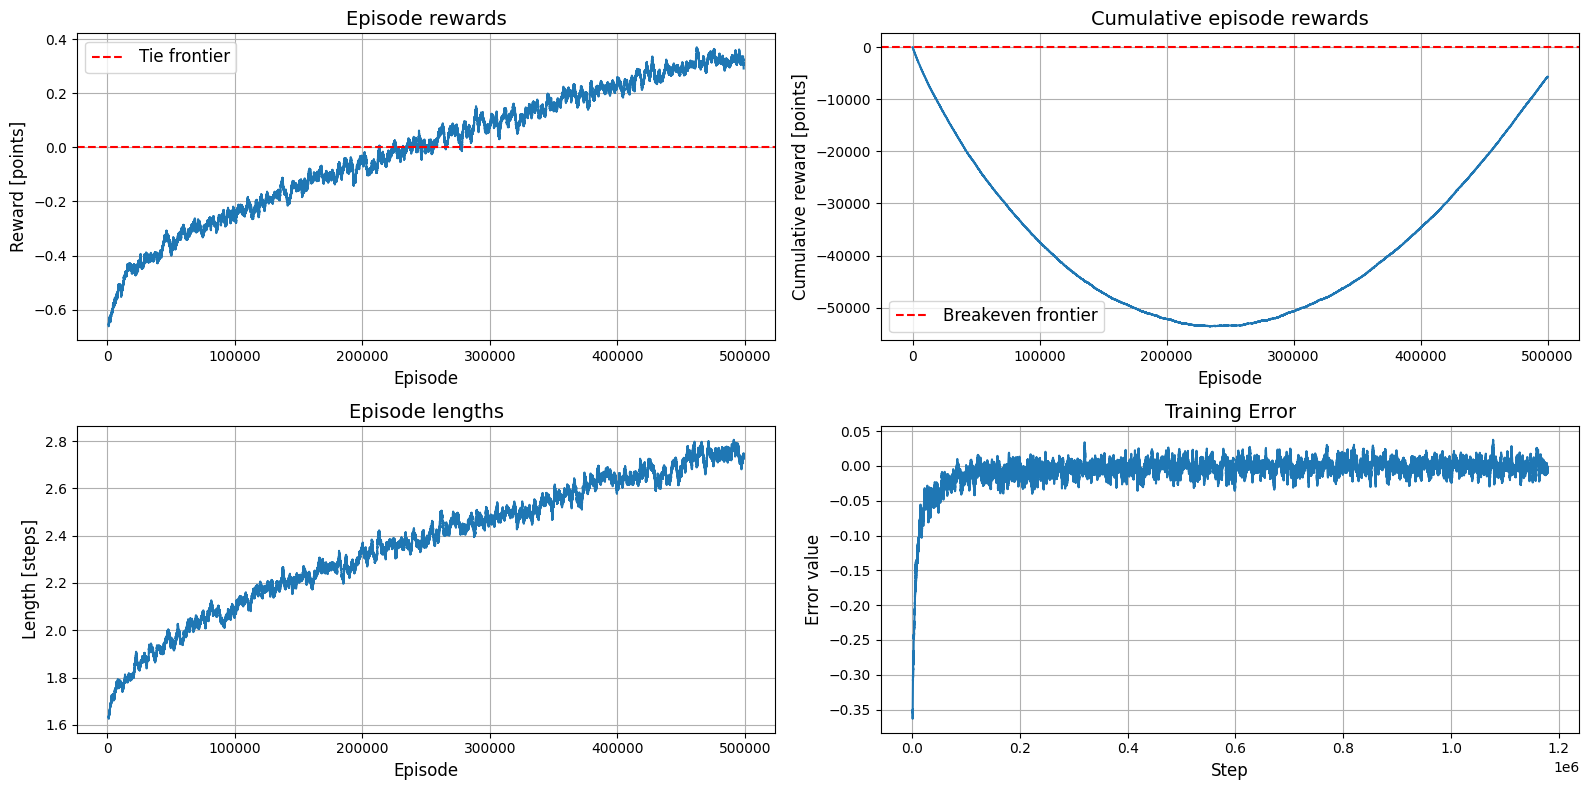

In [19]:
rolling_length = 2000
figure = show_training_stats(env, training_error, rolling_length)
figure.savefig("./analysis/training.jpg", dpi=300)

As we can see, the agent has acquired the policy, that allows to get the average score above 0.3. In terms of game, the average agent's bid multplication factor would be 1.3.

In [20]:
get_rewards_stats(env)

,Count,Rate
Lose,226247,0.452494
Victory,199717,0.399434
Tie,63596,0.127192
Blackjack,10440,0.020880


### Policy representation
By converting the Q-table to the heatmaps, we reveal the agent's logic that it has obtained during the training.

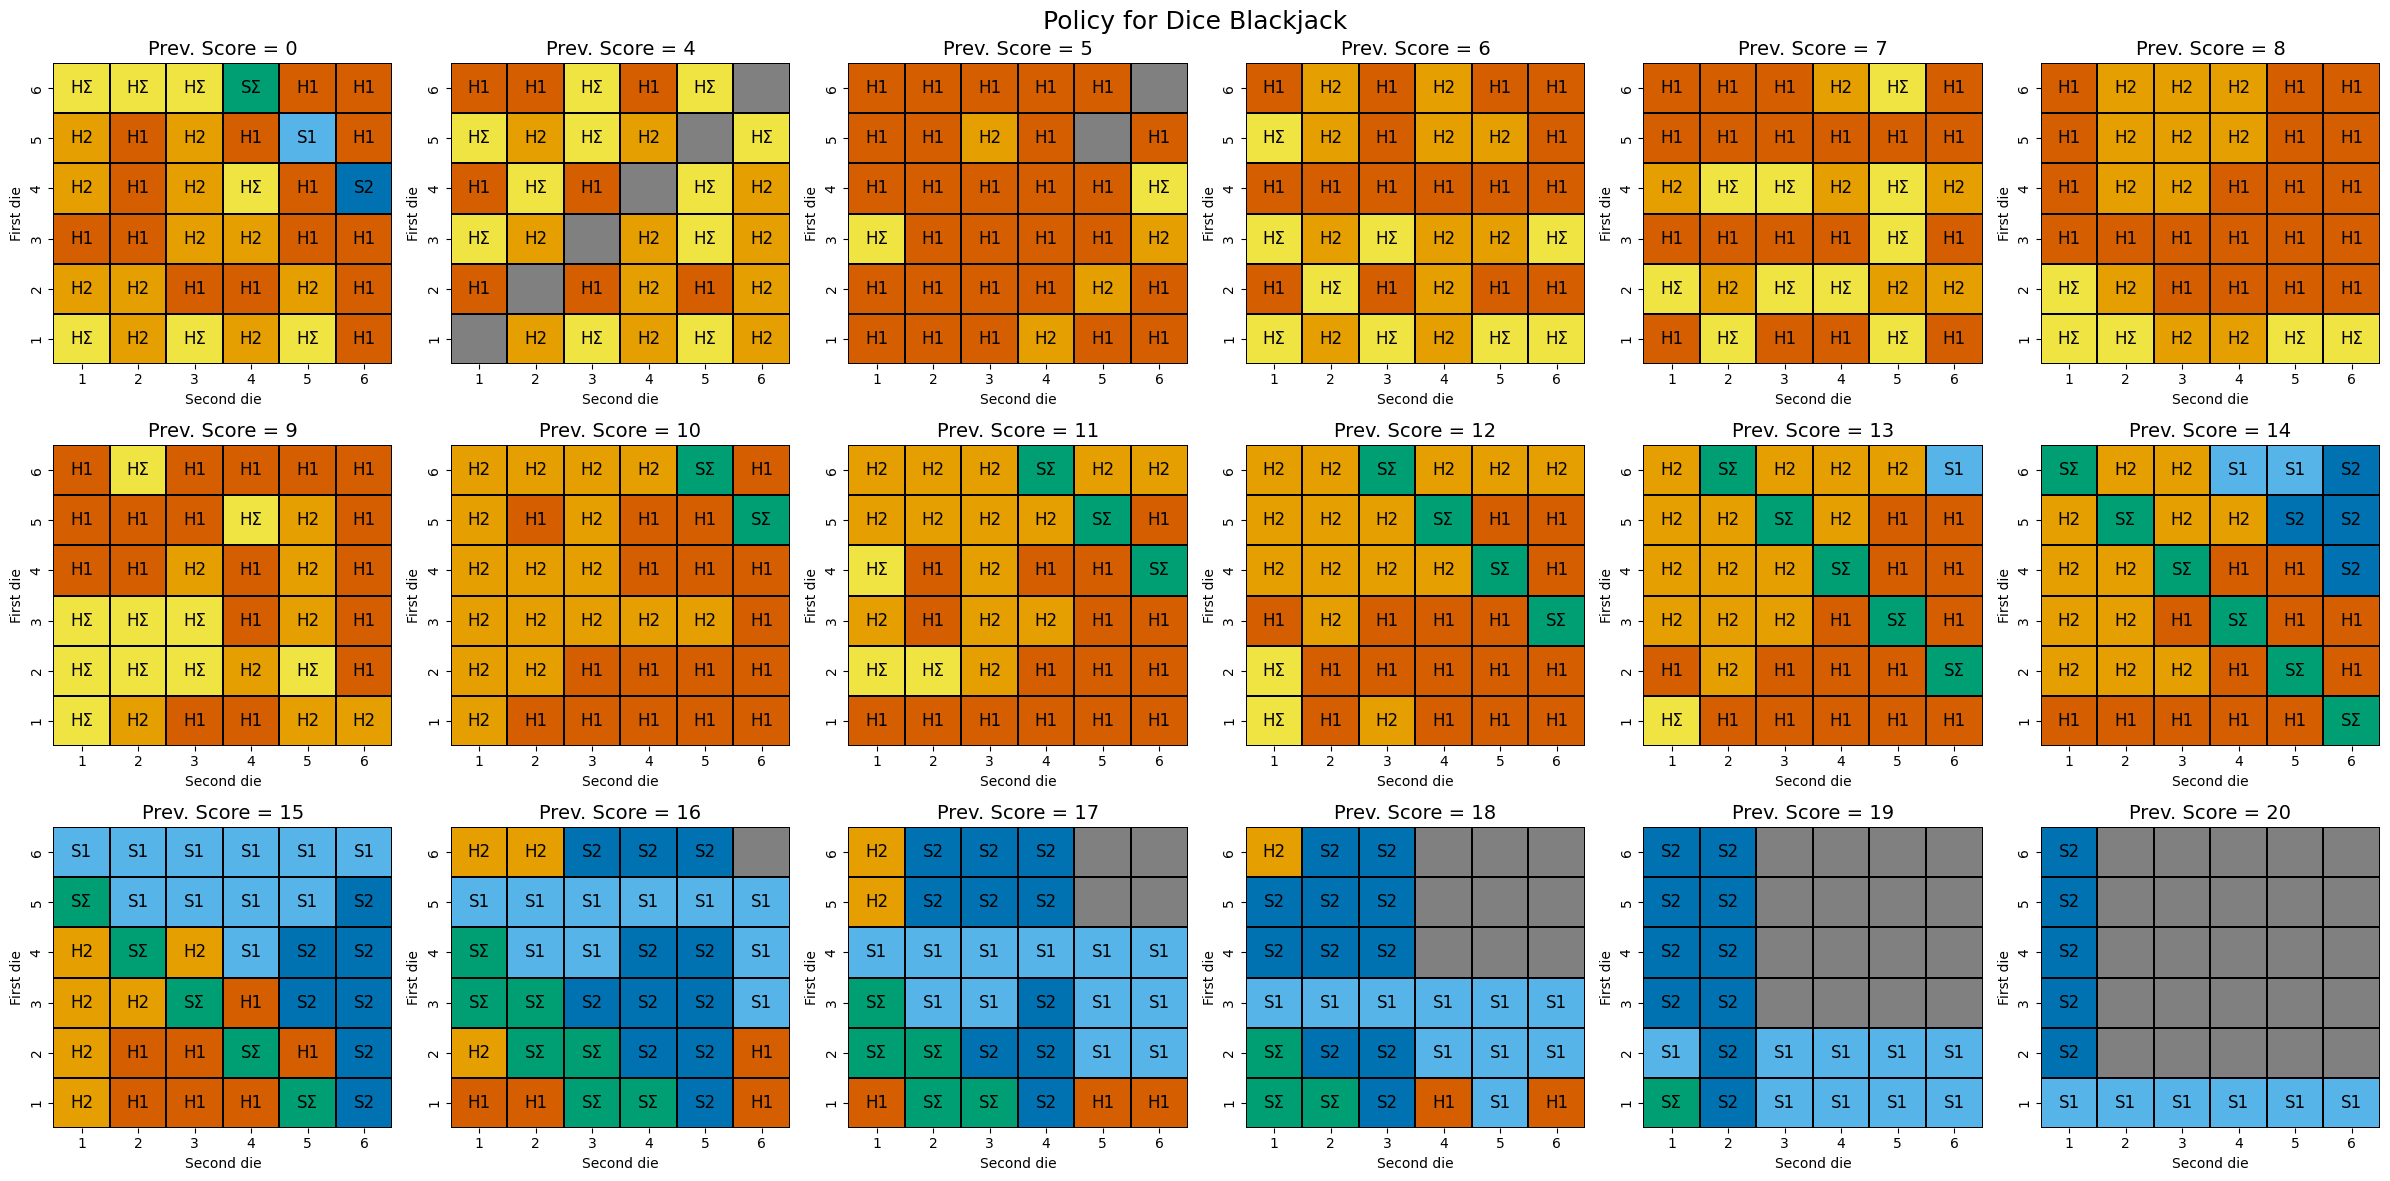

In [21]:
action_info = {
    0: ("H1", "#D55E00"),
    1: ("H2", "#E69F00"),
    2: ("HΣ", "#F0E442"),
    3: ("S1", "#56B4E9"),
    4: ("S2", "#0072B2"),
    5: ("SΣ", "#009E73"),
}

action_table = convert_q_table(agent.get_q_table())
figure = plot_policy_tables_18(action_table, action_info)
figure.savefig("./analysis/policy.jpg", dpi=300)

You may try the policy by yourself and validate it manually.

### Inference

For the inference, we have played another 50.000 episodes and recorded 60 first steps to the `.gif` file.

In [22]:
n_episodes = 50_000
env = DiceBlackJack(render_mode="rgb_array")
env = gym.wrappers.RecordVideo(
    env,
    video_folder="./analysis",
    fps=1,
    video_length=60,
    episode_trigger=lambda x: x == 0,
    name_prefix="dice-blackjack",
)
env = gym.wrappers.RecordEpisodeStatistics(env, n_episodes)

c:\Users\mekor\Documents\Skoltech\Term-7\RL\dice-blackjack-mdp\.venv\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\mekor\Documents\Skoltech\Term-7\RL\dice-blackjack-mdp\analysis folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [23]:
for _ in trange(n_episodes, desc="Inference"):
    obs, _ = env.reset()
    done = False
    while not done:
        action = agent.respond(obs)
        obs, reward, done, _, _ = env.step(action)

Inference: 100%|██████████| 50000/50000 [00:22<00:00, 2184.30it/s]


In [24]:
mp4_to_gif(folder="./analysis")

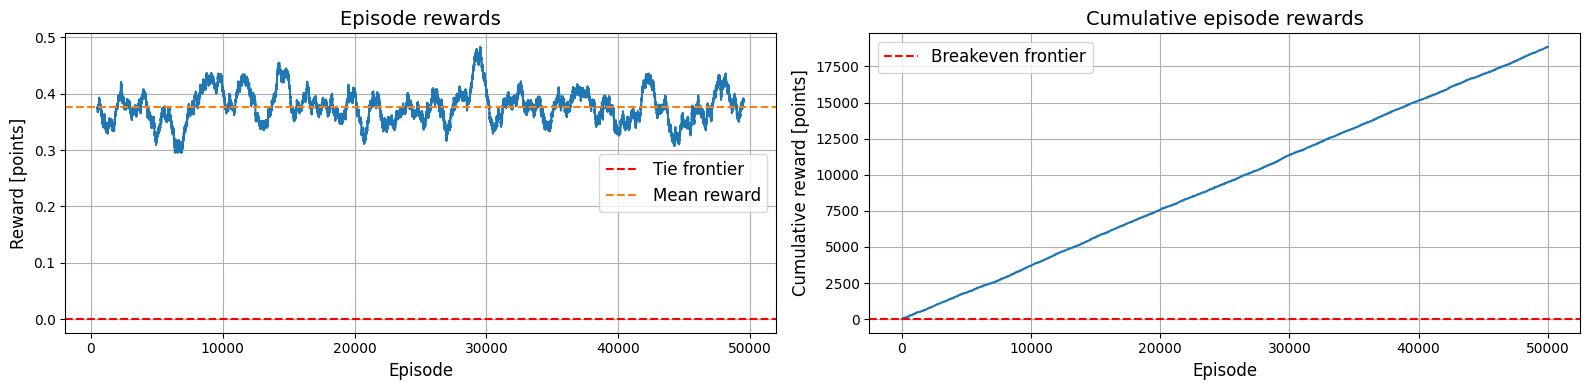

In [25]:
figure = show_inference_stats(env)
figure.savefig("./analysis/validation.jpg", dpi=300)

In [26]:
get_rewards_stats(env)

,Count,Rate
Victory,28341,0.56682
Lose,11900,0.23800
Tie,8554,0.17108
Blackjack,1205,0.02410


It is evident, that the agent's policy has the positive mean reward. In particular, the rate of victories on test run exceeds 0.50 rate.